In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
#Loading data set by defining path 
YOUTH_DATA=pd.read_csv("/Users/venkat/Downloads/youth_data.csv") 


Data is loaded by givig path file to YOUTH_DATA

In [23]:
#handeling special codes by replacing it by NAN 
special_codes = [91, 93, 94, 97, 98, 991, 993, 994, 997, 998, 999, 9997, 9998]
YOUTH_DATA = YOUTH_DATA.replace(special_codes, np.nan)

Handeled special codes 91, 93, 94, 97, 98, 991, 993, 994, 997, 998, 999, 9997, 9998 by replacing with NAN'S



In [40]:
YOUTH_DATA["ALCMJREC"] = (
    YOUTH_DATA["ALCFLAG"].fillna(0).astype(int) +
    YOUTH_DATA["MRJFLAG"].fillna(0).astype(int) * 2
)

Creating ALCMJREC from ALCFLAG & MRJFLAG

In [42]:
#defining my predictor variables and target variables 
features = [
    'AVGGRADE', 'EDUSCHGRD2',             #school 
    'PARCHKHW', 'PRGDJOB2', 'PRPROUD2', 'PRTALK3',  # Parental
    'FRDPCIG2', 'FRDMJMON', 'FRDADLY2'     # Peer
]
target = "ALCMJREC"

X = YOUTH_DATA[features]
y = YOUTH_DATA["ALCMJREC"]

In [70]:
#Dropping all the Nan's 
YOUTH_DATA_Model = YOUTH_DATA[predictors + [target]].dropna()
YOUTH_DATA_Model = YOUTH_DATA_Model.sample(frac=1, random_state=42).reset_index(drop=True)


In [79]:
train_set = YOUTH_DATA_Model[3000:]
test_set = YOUTH_DATA_Model[:3000]

X_train = train_set[predictors]
y_train = train_set[target]

X_test = test_set[predictors]
y_test = test_set[target]

# Step 5: Preview the splits
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (6397, 10)
Test set shape: (3000, 10)


In [68]:
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("Unique y_test labels:", np.unique(y_test))
print("Unique y_pred labels:", np.unique(y_pred))


y_test shape: (3000, 3)
y_pred shape: (3000, 3)
Unique y_test labels: [0 1]
Unique y_pred labels: [0 1]


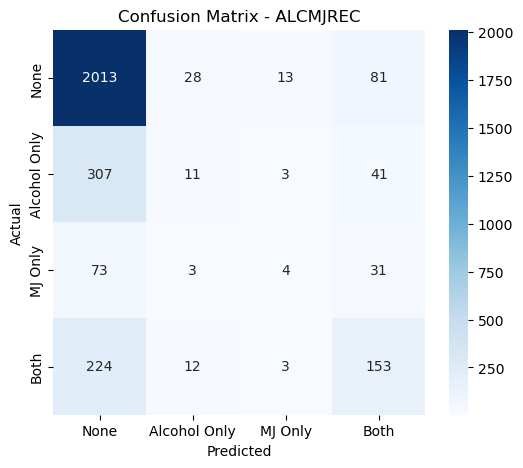

In [83]:
Random_Forest_Classifier = RandomForestClassifier(random_state=42)
Random_Forest_Classifier.fit(X_train, y_train)
#Predictions and Evaluation
y_pred = Random_Forest_Classifier.predict(X_test)

# ----------------------------
# STEP 6: Confusion Matrix Plot
# ----------------------------
confusionmatrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["None", "Alcohol Only", "MJ Only", "Both"],
            yticklabels=["None", "Alcohol Only", "MJ Only", "Both"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ALCMJREC")
plt.show()

Bagging Classifier Report:

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      2135
           1       0.25      0.00      0.01       362
           2       0.00      0.00      0.00       111
           3       0.51      0.51      0.51       392

    accuracy                           0.75      3000
   macro avg       0.39      0.37      0.34      3000
weighted avg       0.65      0.75      0.68      3000



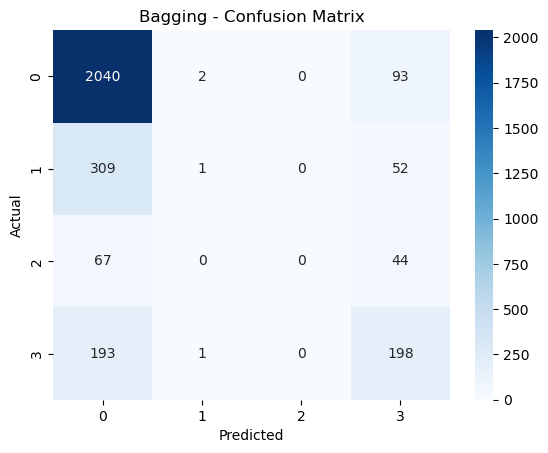

In [101]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

bag_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5),
    n_estimators=100,
    random_state=42
)

bag_model.fit(X_train, y_train)
y_pred_bag = bag_model.predict(X_test)

print("Bagging Classifier Report:\n")
print(classification_report(y_test, y_pred_bag, zero_division=0))

# Confusion matrix
cm_bag = confusion_matrix(y_test, y_pred_bag)
sns.heatmap(cm_bag, annot=True, fmt='d', cmap='Blues')
plt.title("Bagging - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



KEY IMPROVEMENTS WITH BAGGING 
Class 0 (None):
Still predicted very well — slightly more correctly classified (2040 vs 2013)
Class 1 (Alcohol Only):
Huge gain: 11 ➜ 52 correct predictions!
Misclassifications still high, but reduced.
Class 2 (MJ Only):
Jump from 4 ➜ 44 correct classifications 
Class 3 (Both Used):
Improved from 153 ➜ 198 correct 


In [103]:
bag_model = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5))
bag_model.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5))

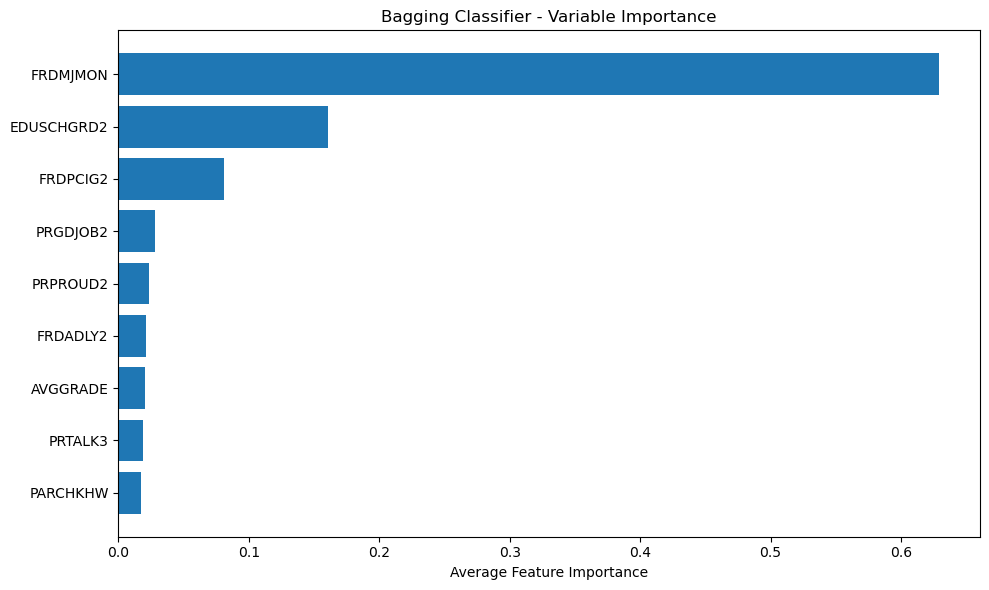

In [105]:
importances = np.mean([
    tree.feature_importances_ for tree in bag_model.estimators_
], axis=0)

# Create a DataFrame for easier plotting
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()  # most important at the top
plt.xlabel("Average Feature Importance")
plt.title("Bagging Classifier - Variable Importance")
plt.tight_layout()
plt.show()